# Model-Based Reinforcement Learning

## Principle
We consider the optimal control problem of an MDP with a **known** reward function $R$ and subject to **unknown deterministic** dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In **model-based reinforcement learning**, this problem is solved in **two steps**:
1. **Model learning**:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. **Planning**:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

(We can easily extend to unknown rewards and stochastic dynamics, but we consider the simpler case in this notebook for ease of presentation)


## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with **sparse rewards**, the chance of obtaining a reward randomly is **negligible**, which prevents any learning.
* However, even in the **absence of rewards** we still receive a **stream of state transition data**. We can exploit this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have **complex dynamics** but a **simple optimal policy or value function**. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have **simple dynamics** but **complex policies/value functions**. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular **structure**: for instance, any problem involving motion of physical objects will be **continuous**. It can also be **smooth**, **invariant** to translations, etc. This knowledge can then be incorporated in machine learning models to foster efficient learning. In contrast, there can often be **discontinuities** in the policy decisions or value function: e.g. think of a collision vs near-collision state.

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to **learn faster** than model-free techniques (see e.g. [[Sutton, 1990]](http://papersdb.cs.ualberta.ca/~papersdb/uploaded_files/paper_p160-sutton.pdf.stjohn)).

### Interpretability
In real-world applications, we may want to know **how a policy will behave before actually executing it**, for instance for **safety-check** purposes. However, model-free reinforcement learning only recommends which action to take at current time without being able to predict its consequences. In order to obtain the trajectory, we have no choice but executing the policy. In stark contrast, model-based methods a more interpretable in the sense that we can probe the policy for its intended (and predicted) trajectory.

## Our challenge: Automated Parking System

We consider the **parking-v0** task of the [highway-env](https://github.com/eleurent/highway-env) environment. It is a **goal-conditioned continuous control** task where an agent **drives a car** by controlling the gaz pedal and steering angle and must **park in a given location** with the appropriate heading.

This MDP has several properties wich justifies using model-based methods:
* The policy/value is highly dependent on the goal which adds a significant level of complexity to a model-free learning process, whereas the dynamics are completely independent of the goal and hence can be simpler to learn.
* In the context of an industrial application, we can reasonably expect for safety concerns that the planned trajectory is required to be known in advance, before execution.

###  Warming up
We start with a few useful installs and imports:

In [1]:
""" Remove " > /dev/null 2>&1" to see what is going on under the hood"""
# Install environment and visualization dependencies 
!pip install git+https://github.com/eleurent/highway-env#egg=highway-env  > /dev/null 2>&1
#!pip install gym pyvirtualdisplay > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# Environment
import gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


We also define a simple helper function for visualization of episodes:

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_videos(path="video"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

XStartTimeoutError: Failed to start X on display ":1001" (xdpyinfo check failed).

### Let's try it!

Make the environment, and run an episode with random actions:

In [9]:
env.close()

In [4]:
env = gym.make("parking-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_videos()

KeyboardInterrupt: 

The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [5]:
print("Observation format:", obs)

Observation format: {'observation': array([-0.22440158,  0.36577995, -0.26734558,  1.12603641,  0.2310004 ,
       -0.97295366]), 'achieved_goal': array([-0.22440158,  0.36577995, -0.26734558,  1.12603641,  0.2310004 ,
       -0.97295366]), 'desired_goal': array([2.600000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
       6.123234e-17, 1.000000e+00])}


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [6]:
env.action_space.low

array([-1., -1.], dtype=float32)

In [246]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])
def tt(x):
    return torch.from_numpy(x).double()

class OrnsteinUhlenbeck():
    def __init__(self, size, nmin=-.5, nmax=0.5, alow=-1, ahigh=1):
        self.n = np.zeros(size)
        self.std = 0.4
        self.nmin = nmin
        self.nmax = nmax
        self.alow = alow
        self.ahigh = ahigh
        self.size = size
        
    def __call__(self):
        self.n += np.clip(self.n + np.random.normal(0, self.std, self.size), self.nmin, self.nmax)
        return self.n
    
    def reset(self):
        self.x = 0
        

def collect_interaction_data(env, size):
    """
        QUESTION 1: Collect a dataset of random interaction with the environment.
        
        1. The env.action_space has a useful sample() method to generate independent uniform noise
        2. States and actions should be cast as torch.Tensor, and stored into Transition tuples.
        3. (Optional): In order to improve exploration, some kind of temporal consistent noise should be used.
          A high-frequency noise quickly cancels itself out and will not be able to explore very deeply. 
          Holding an action for a longer time enables to build-up velocity and explore further.
          Ornstein-Uhlenbeck noise processes are often used for continuous control tasks, but here a simple
          action repeat strategy will be enough.
        
    :param env: an OpenAI Gym environment
    :param size: the desired number of transitions 
    :return: a list of Transitions
    """
    transitions = []
    nmin = env.action_space.low
    
    ou_process = OrnsteinUhlenbeck(2)
    while len(transitions) < size:
        o = env.reset()
        ou_process.reset()
        d = False
        a = a_start = env.action_space.sample()
        while not d:
            a = np.clip(a + ou_process(), env.action_space.low, env.action_space.high)
            #a = env.action_space.sample()
            o_next, r, d, inf = env.step(a)
            transitions.append(Transition(state=tt(o['observation']), action=tt(a), next_state=tt(o_next['observation'])))
            o = o_next
    return transitions

data_size = 5000
data = collect_interaction_data(env, size=data_size)

# the code below will check that collect_interaction_data implementation is correct-ish
assert isinstance(data, list) and len(data) == data_size, "return value should be a list of length data_size"
assert isinstance(data[0], Transition), "return value should be a list whose elements are Transition tuples"
assert all([isinstance(field, torch.Tensor) and field.dtype == torch.float64 for field in data[0]]), "Transition tuples should contain torch tensors whose types are float64"

# print the first transition
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.1006, -0.9949],
       dtype=torch.float64), action=tensor([-0.9281,  0.4923], dtype=torch.float64), next_state=tensor([-6.1573e-05,  6.1567e-04, -1.7748e-02,  1.8477e-01,  9.5614e-02,
        -9.9542e-01], dtype=torch.float64))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems* 

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation for states and actions comes from the Control Theory community and is typically used when they are continuous. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [247]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)
        
        self.A = torch.nn.Sequential(self.A1, torch.nn.ReLU(),  torch.nn.Linear(hidden_size, hidden_size), torch.nn.ReLU(), self.A2)
        self.B = torch.nn.Sequential(self.B1, torch.nn.ReLU(),torch.nn.Linear(hidden_size, hidden_size),  torch.nn.ReLU(), self.B2)
    def forward(self, x, u):
        """
            QUESTION 2: Predict x_{t+1} = f(x_t, u_t)
            
            Denoting the state size, action size, and batch size as S, A, N: 
            
            1. Concatenate the states and actions (x,u) to a single tensor.
            2. Compute the coefficients A(x,u) and B(x,u) by forwarding the two fully-connected networks with
               F.relu activations and linear output. This must be done in one pass for the whole batch of (x,u).
            3. Reshape the obtained A and B vectors into a batch of SxS and SxA matrices, S is state size and 
               A is action size. The resulting tensors should be of shape (N, S, S) and (N, S, A).
            4. Compute the batch of state derivatives \dot{x}, by using the matrix multiplication operator @. 
               It should be of shape (N, S).
            5. Integrate the states dynamics over a timestep dt to obtain the next states x_{t+1}.
            6. (Optional) Inductive bias: to accelerate learning, implement the knowledge that the laws of physics
               are uniform across space, and hence A(x,u) and B(x,u) cannot depend on the car coordinates (the  
               two first component of the state x).
            
        :param Tensor x: a batch of states, of shape (N, S)
        :param Tensor u: a batch of actions, of shape (N, A)
        :return a Tensor of predicted next states, of shape (N, S)
        """
        x = x.double()
        u = u.double()
        xu = torch.cat([x,u], 1).float()
        A = self.A(xu).reshape(-1, self.state_size, self.state_size).double()
        B = self.B(xu).reshape(-1, self.state_size, self.action_size).double()
        
        # Bias
        #A[:, :, :2] *= 0

        dx = (A@x.double().reshape(A.shape[0], -1, 1) + B@u.double().reshape(A.shape[0], -1, 1))

        x_next = x + dx.double().squeeze(-1)
        #print(x.shape, x_next.shape)
        return x_next
        
        
        
        


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])

#  Forward a sample transition. 
#  unqueeze(0) is used to generate a batch of 1 element, by adding a new batch dimension of size 1.
state, action = data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)
next_state = dynamics(state, action).detach()  # detach() is used here because gradients are unnecessary
assert state.shape == next_state.shape
assert not torch.equal(next_state, state)
print("Forward initial model on a sample transition:", next_state)

Forward initial model on a sample transition: tensor([[-0.2667, -0.0639,  0.1267,  0.0206, -0.0640, -1.1435]],
       dtype=torch.float64)


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

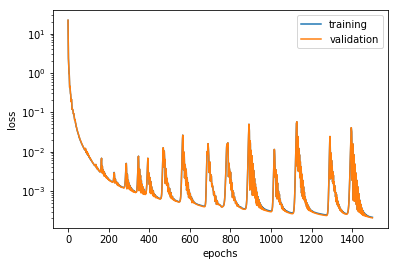

In [248]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.02)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t):
    """
        QUESTION 3: Compute the loss L^2 of the model f_theta on a batch of data D.
        
        1. You can use either the sum() and **2 operators, or the built-in torch.nn.MSELoss()
        
    :param model: the dynamics model 
    :param data_t: a tuple of tensors (states, actions, next_states)
    :return: the model loss L^2(f_theta, D)
    """
    loss = 0
    batch_state = data_t[0]
    batch_next_state = data_t[2]
    batch_action = data_t[1]
    
    preds = model(batch_state, batch_action)
    
    loss = torch.mean((preds-batch_next_state)**2)
    
    return loss

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in tnrange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


In [233]:
t = torch.zeros(6)

t.repeat(100,1).shape

torch.Size([100, 6])

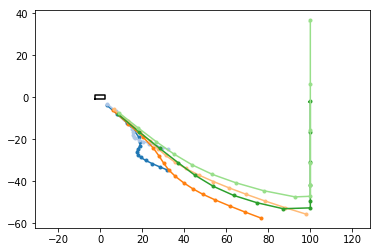

In [234]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def predict_batched(state, actions, model):
    states = []
    for a_batch in actions:
        state = model(state.repeat(a_batch.shape[0], 1)[:a_batch.shape[0]], a_batch)
        states.append(state)
    return torch.stack(states)

def plot_trajectory(states, color):
    scales = np.array(highway_env.envs.parking_env.ParkingEnv.DEFAULT_CONFIG["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

Do the predicted trajectories look realistic? If not, you can try to:
- Collect more data in $D$
- Increase the model capacity (size of hidden layer, number of layers)
- Increase the number of training epochs or change the learning rate
- Add regularization

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [235]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    rewards = -torch.pow(torch.norm((states.double()-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

def reward_batched(states, goal, H,  gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape).double()
    states = states.double()
    reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    rewards = -torch.pow(torch.norm((states-goal).reshape(-1, 6)*reward_weigths.double(), p=1, dim=-1), 0.5)
    rewards = rewards.reshape(H, -1, 1)
    
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return torch.sum(rewards, 0)



obs = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

RuntimeError: expected type torch.DoubleTensor but got torch.FloatTensor

## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [241]:
def cem_planner(state, goal, action_size, model, horizon=3, population=100, selection=10, iterations=5):
    """
        QUESTION 4: Planning with the Cross-Entropy Method
        
        Denoting the horizon, population size, selection size, state size and action size as H, P, K, S, A:
        
        1. Initialize the distribution of actions (a_1, ..., a_H) to a standard normal N(0,1), by setting their
           mean mu and standard deviations sigma, each of shape (H, 1, A).
        2. (Loop over iterations).
        3. Sample a population of P sequences of actions from the parametrized normal distribution. 
           You can use torch.randn(shape) to generate a tensor of normally distributed values in N(0,1).
           The sampled actions should belong the the action space boundaries (-1, 1).
           These sequences should be stored in a tensor of shape (H, P, A).
        4. Predict the corresponding trajectories starting from the current state, and store them in a tensor
           of shape (H, P, S). The predict_trajectory() method defined above can be used.
        5. Compute the rewards along the trajectories using the reward_model(), and the corresponding trajectory
           returns by summing over the horizon.
        6. Find the K best returns by using the torch.topk() method.
        7. Update the distribution parameters to fit the selected actions.  You can use torch.mean() and
           torch.std().
        8. (After loop completion) return the first mean action.
        
    :param Tensor state: the current state, of shape (S,)
    :param Tensor goal: the desired goal, of shape (S,)
    :param int action_size: the size A of the action space
    :param int horizon: the planning horizon H, i.e. the number of timesteps
    :param int population: the number P of predicted trajectories
    :param int selection: the number K of best trajectories selected to fit a new distribution
    :param int iterations: the number of iterations
    :return: the recommended action, of shape (A,)
    """
    mu = torch.zeros((horizon, 1, action_size))
    sigma = torch.ones((horizon, 1, action_size))
    
    for i in range(iterations):
        
        population_list = []
        for i_pop in range(population):
            acts = torch.randn((horizon, 1, action_size))*sigma + mu
            acts = torch.clamp(acts, -1, 1)
            population_list.append(acts)
        
        actions = torch.cat(population_list, 1)
        trajectories = predict_batched(state=state, actions=actions, model=model)
        rewards = reward_batched(states=trajectories, goal=goal, H=horizon)
        
        # take elite
        vals, idxs = torch.topk(rewards.flatten(), k=selection)
        elite_actions = actions[:, idxs]
        
        # fit dist 
        mu = torch.mean(elite_actions, 1)
        sigma = torch.std(elite_actions, 1)
        
    return mu[0]
        
    
  
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0],
                     model=dynamics)
assert env.action_space.contains(action.numpy())
print("Planned action:", action)

Planned action: tensor([ 0.9500, -0.2679])


## Visualize a few episodes

En voiture, Simone !

In [242]:
env = gym.make("parking-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: False)
all_eps = []
for episode in tnrange(3, desc="Test episodes"):
    obs, done = env.reset(), False
    ep_rewards = []
    while not done:
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0], model=dynamics, population=100)
        obs, reward, done, info = env.step(action.numpy())
        ep_rewards.append(reward)
    all_eps.append(ep_rewards)
    
env.close()
show_videos()

NameError: name 'show_videos' is not defined

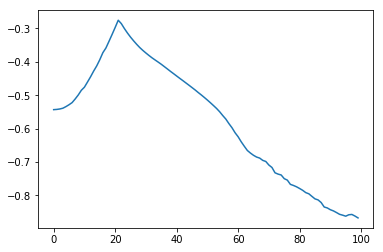

In [245]:
rewards = np.asarray(all_eps)
plt.plot(rewards[0])

Is the performance satisfying? 
If not, try to identify if the problem lies with the dynamics model or the planner.
If you think that the planner is at fault, you can try to:
- Increase the size of the population.
- Increase the planning horizon.
- Add action repeat in the planning procedure, in order to increase the effective planning horizon without increasing
  the size of the optimization space (sampled sequences of actions).

## Limits

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a **bias** that can only **decrease the true performance** of the corresponding planned policy. This is called the problem of model bias.

In some MDPs, even slight model errors lead to a dramatic drop in performance, as illustrated in the beginning of the following video:

[![Approximate Robust Control of Uncertain Dynamical Systems](https://img.youtube.com/vi/8khqd3BJo0A/0.jpg)](https://www.youtube.com/watch?v=8khqd3BJo0A)

The question of how to address model bias belongs to the field of **Safe Reinforcement Learning**. 

### [L'appel du vide](https://www.urbandictionary.com/define.php?term=L%27appel%20du%20vide)

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and **hallucinate** important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to **exploit** these hallucinated high rewards and will steer the agent towards **unknown** (and thus dangerous) **regions** where the model is erroneously optimistic.

### Computational cost of planning

At test time, the planning step typically requires **sampling a lot of trajectories** to find a near-optimal candidate, wich may turn out to be very costly. This may be prohibitive in a high-frequency real-time setting. The **model-free** methods which directly recommend the best action are **much more efficient** in that regard.